# Exploration of the Titanic data set

In [111]:
!pip install seaborn
!pip install scikit-learn

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Section 1. Exploration

### Question 1

Load the titanic using `pandas`. It is located in `datasets/titanic.csv`. Using the function `head()` and `info()`, which issues do you identify which need to be solved before to learn a machine learning model.

In [113]:
data = pd.read_csv('datasets/titanic.csv')

### Question 2

- By checking the variable `Survived`, is the dataset balanced? What will be the chance level accuracy?
- What variables contain more missing values?

<Axes: >

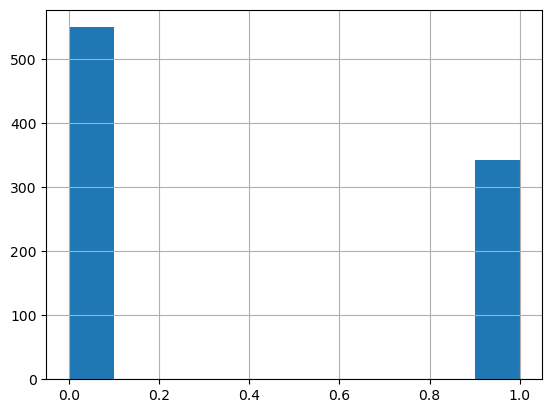

In [114]:
data['Survived'].hist()

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Question 3

Using the `pairplot` of `seaborn` on the `Age`, `Pclass`, `Fare`, `Sex`, and `Survived` columns, identify some intuitions regarding the correlation between the survival and the features. Make some plots to confirm your intuition.

array([-24.26266581, -32.56886142, -27.61004199, -27.59150666,
       -28.73540609])

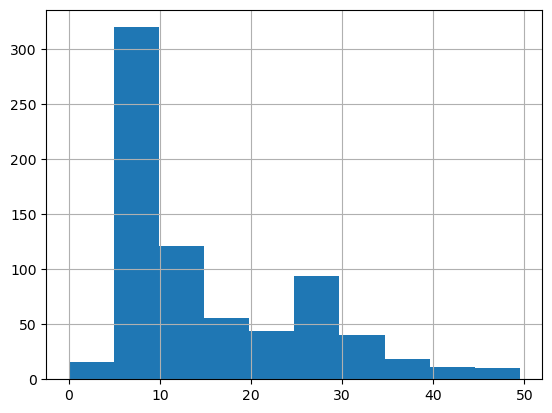

In [145]:
from sklearn.ensemble import RandomForestRegressor
is_children = (data[['Age']] <= 14).astype(float)
#is_children.hist()

data[data['Fare'] < 50]['Fare'].hist()
cross_val_score(RandomForestRegressor(), is_children, data['Fare'], scoring='neg_mean_absolute_error')


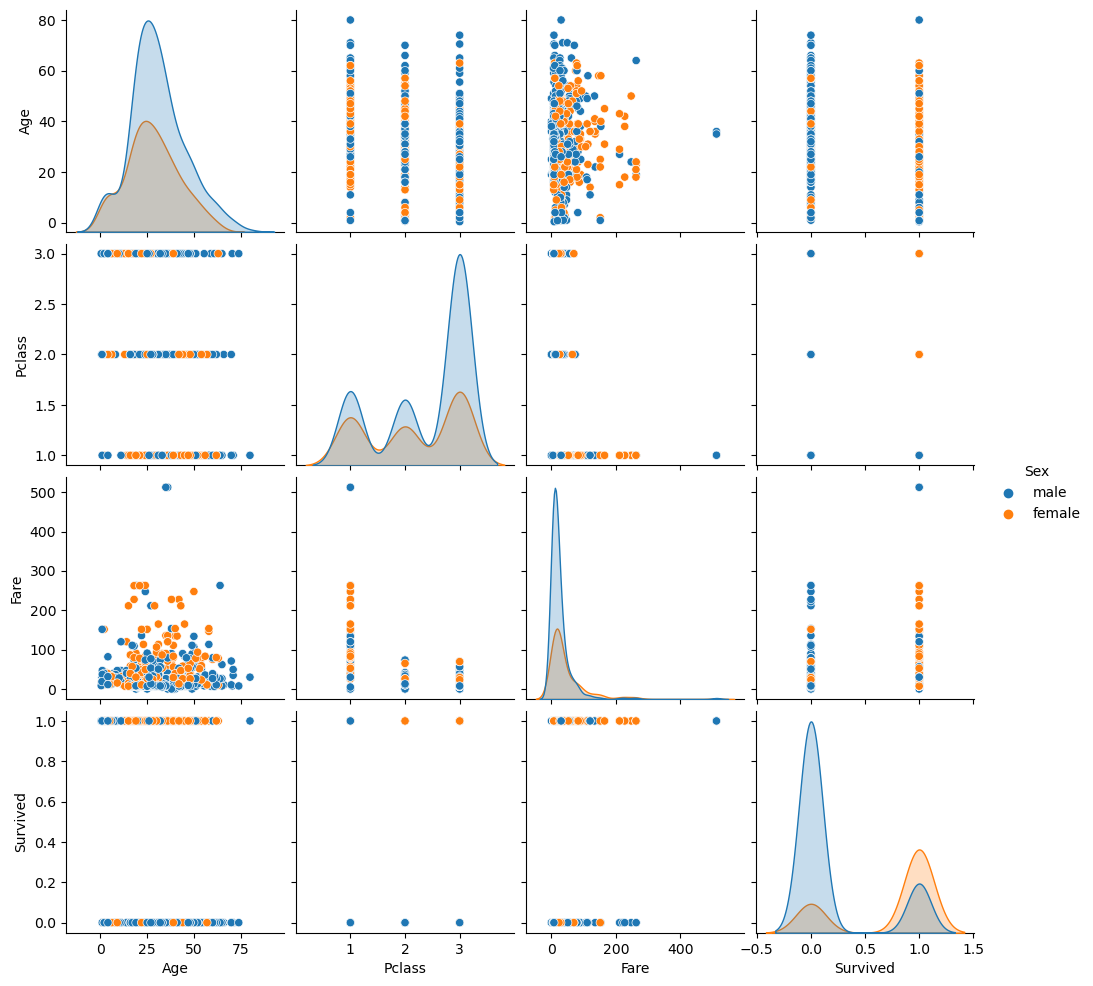

In [116]:
sns.pairplot(data=data[['Age', 'Pclass', 'Fare', 'Sex', 'Survived']], hue='Sex')

## Section 2. Predicting survival

The titanic dataset is an heterogeneous dataset and it gives the opporunity to show the scikit-learn pipelining features. We will show in this notebook how to make a simple classification pipeline. The aim is to predict or not if a passenger survived the titanic trip.

In [117]:
data = pd.read_csv('datasets/titanic.csv', index_col='PassengerId')

In [118]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


First, we need to split the dataset into 2 arrays: the data array and the classification array.

In [119]:
label = data['Survived']
data = data.drop(columns='Survived')

Because the data type in the titanic dataset, we need to specifically have different preprocessing for the continuous and categorical columns. The `ColumnTransformer` of scikit-learn allows to dispatch different preprocessing depending of the columns. Usually, the categorical variable needs to be encoded while the continuous variable can be standardized.

In [120]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

We are creating three preprocessing:

* an ordinal encoding for the sex;
* a one hot encoding for the remaining categorical features;
* and a standardization for the continuous features.

In addition, missing values will be filled up with either the median (for continuous variable) or a constant value (categorical variable).

In [121]:
data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [133]:
preprocessing = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy='constant', fill_value='missing'), OrdinalEncoder()),
        ['Sex']
    ),
    (
        make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()),
        ['Fare', 'Age']
    )
)

preprocessing_dt = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy='constant', fill_value='missing'), OrdinalEncoder()),
        ['Sex']
    ),
    (
        SimpleImputer(strategy='mean'),
        ['Fare', 'Age']
    )
)

preprocessing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 ['Sex']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Fare', 'Age'])])

A logistic regression classifier will be used in which the C parameter will be optimized. We will apply a 5-fold cross-validation scheme to estimate the accuracy of the model.

In [123]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier

In [124]:
# Split the data to design the model on the one called "train"

from sklearn.model_selection import train_test_split
data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=.50)

In [125]:
# Make a dummy classifier which picks the class randomly to have a baseline for other algorithms.
# If an algorithm doesn't perform better than a dummy classifier, then it's are not learning anything
# Evaluate the performance of the dummy classifier through cross validation.

dummy_pipeline = make_pipeline(
    preprocessing,
    DummyClassifier()
)

cross_val_score(dummy_pipeline, data_train, label_train)

array([0.62921348, 0.62921348, 0.62921348, 0.62921348, 0.62921348])

In [126]:
# Make a logistic regression classification pipeline and evaluate it through cross validation. 

lr_pipeline = make_pipeline(
    preprocessing,
    LogisticRegression(C=0.1)
)

cv_lr = cross_val_score(lr_pipeline, data_train, label_train)
print(f"Logistic regression mean {cv_lr.mean():.2} +- {cv_lr.std():.2}")

Logistic regression mean 0.78 +- 0.05


In [127]:
rf_pipeline = make_pipeline(
    preprocessing,
    GridSearchCV(
        RandomForestClassifier(),
        param_grid={'max_depth': [5, 10, 20], 'n_estimators': [5, 10, 100]}
    )
)

cv_rf = cross_val_score(rf_pipeline, data_train, label_train)
print(f"Random forest mean {cv_rf.mean():.2} +- {cv_rf.std():.2}")

Random forest mean 0.78 +- 0.045


In [134]:
dt_pipeline = make_pipeline(
    preprocessing_dt,
    DecisionTreeClassifier(max_depth=4)
)

cv_dt = cross_val_score(dt_pipeline, data_train, label_train)
print(f"Random forest mean {cv_dt.mean():.2} +- {cv_dt.std():.2}")

Random forest mean 0.78 +- 0.066


<Figure size 5000x5000 with 0 Axes>

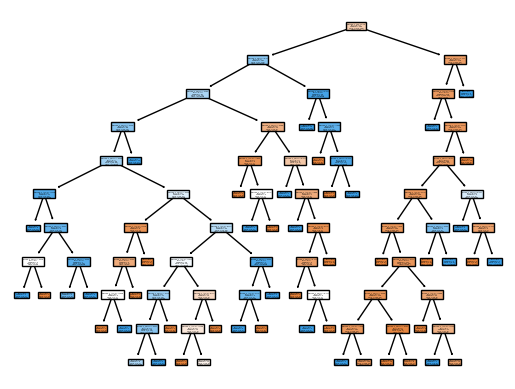

<Figure size 5000x5000 with 0 Axes>

In [154]:
plot_tree(
    rf_pipeline[-1].best_estimator_.estimators_[0],
    feature_names=rf_pipeline[0].get_feature_names_out(),
    filled=True,
    class_names=['Died', 'Survived']
);
plt.figure(figsize=(50, 50))

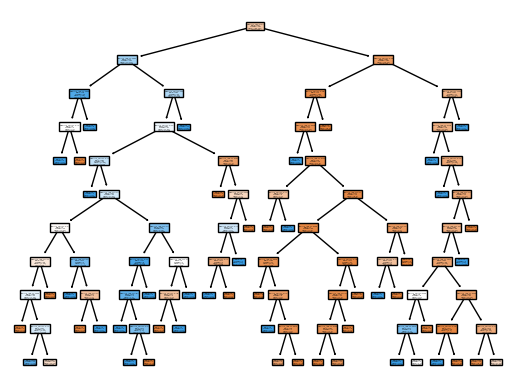

In [155]:
plot_tree(
    rf_pipeline[-1].best_estimator_.estimators_[2],
    feature_names=rf_pipeline[0].get_feature_names_out(),
    filled=True,
    class_names=['Died', 'Survived']
);

['pipeline__Sex' 'simpleimputer__Fare' 'simpleimputer__Age']


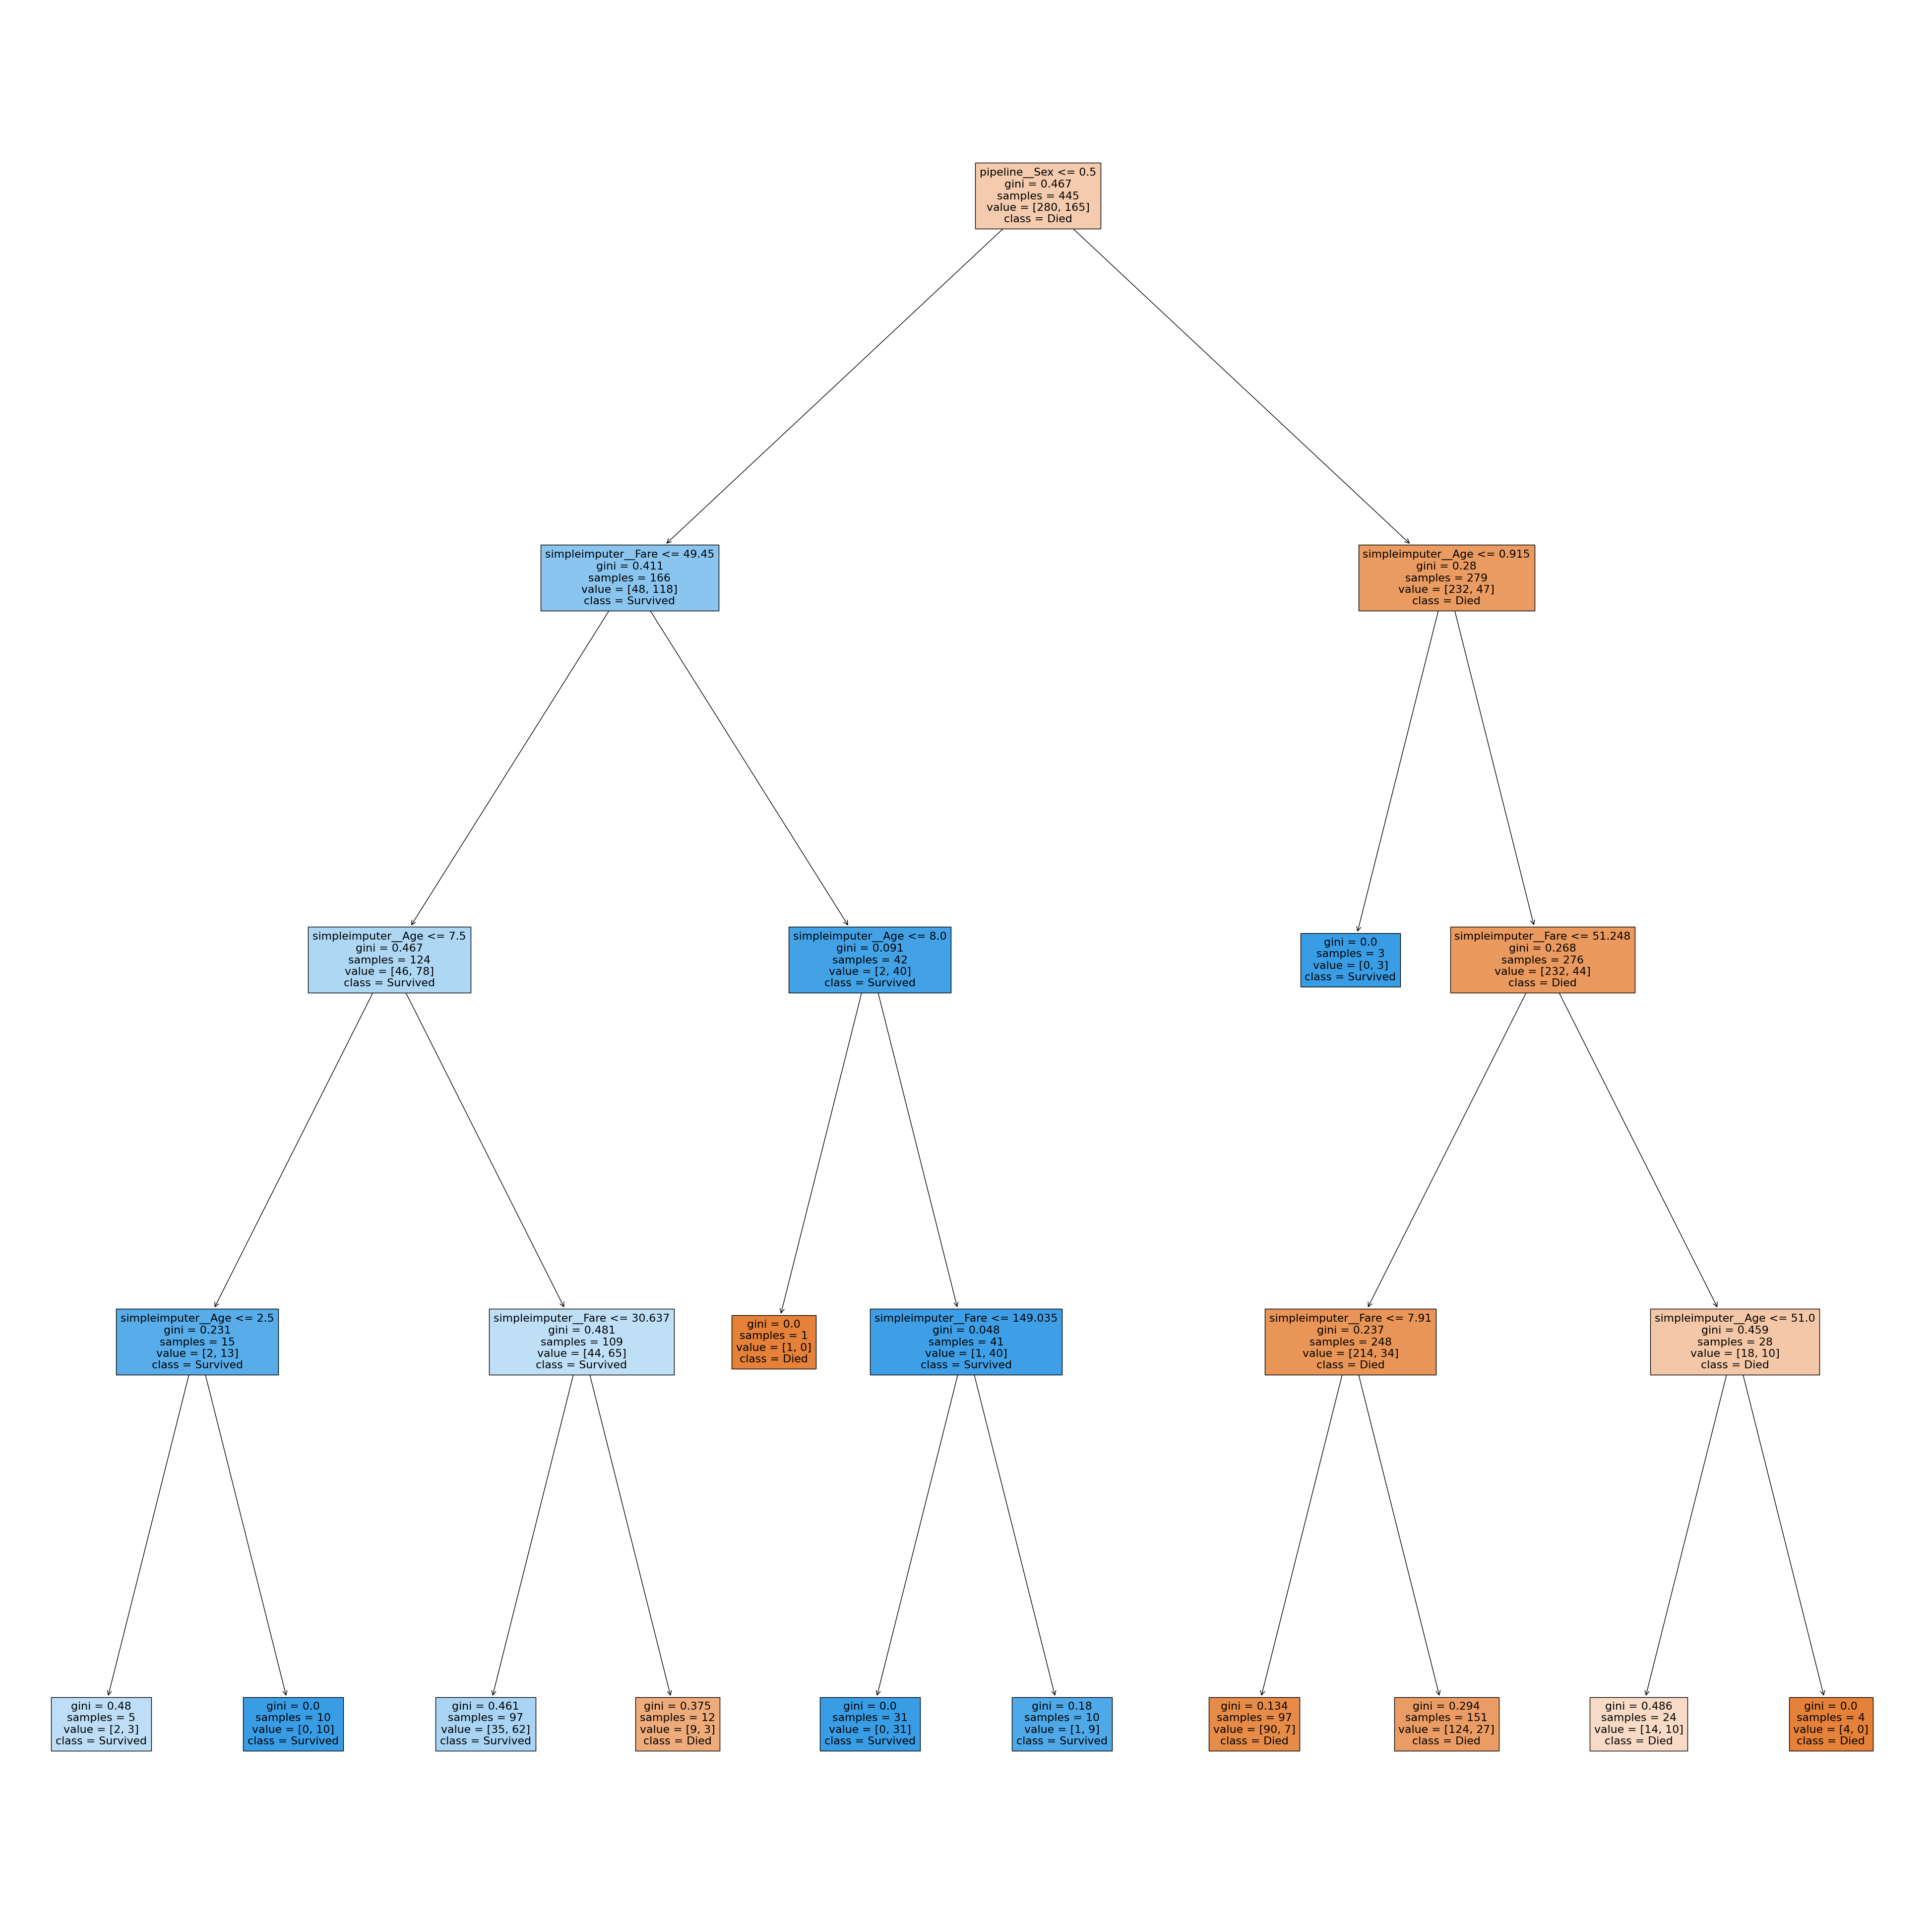

In [135]:
from sklearn.tree importplot_tree
dt_pipeline.fit(data_train, label_train)

print(dt_pipeline[0].get_feature_names_out())
plt.figure(figsize=(50, 50))
plot_tree(dt_pipeline[-1], feature_names=dt_pipeline[0].get_feature_names_out(), filled=True, class_names=['Died', 'Survived']);

(0.0, 1.0)

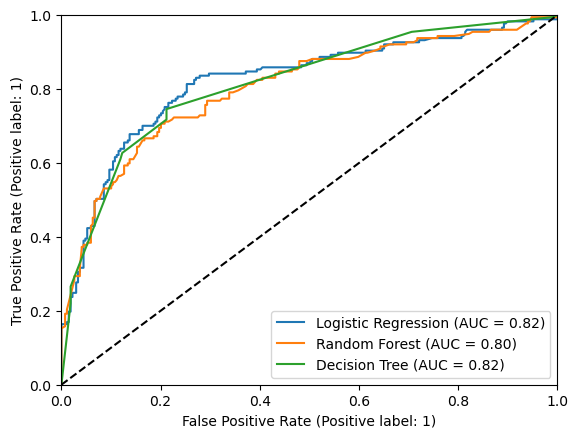

In [130]:
from sklearn.metrics import RocCurveDisplay, roc_curve
lr_pipeline.fit(data_train, label_train)
rf_pipeline.fit(data_train, label_train)
dt_pipeline.fit(data_train, label_train)

ax = plt.gca()

roc_lr_display = RocCurveDisplay.from_estimator(lr_pipeline, data_test, label_test, ax=ax, name='Logistic Regression')
roc_rf_display = RocCurveDisplay.from_estimator(rf_pipeline, data_test, label_test, ax=ax, name='Random Forest')
roc_dt_display = RocCurveDisplay.from_estimator(dt_pipeline, data_test, label_test, ax=ax, name='Decision Tree')

plt.plot((0, 1), (0, 1), c='k', ls='--')
plt.xlim(0, 1)
plt.ylim(0, 1)

### Compare different classification algorithms to predict survival. Specifically through the learning curve and the prediction quality. You can compare
* Logistic Regression, with a parameter C
* LinearSVC
* RandomForestClassifiers

In [131]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Section 3. Model validation and explanatory capabilities. For each model explore fitted model parameters and try to assess their explanatory capabilities

Bare in mind that if `pipe` is our processing pipeline composed of a preprocessing step and a LinearSVC step:
* `linear_svc = pipe._final_estimator` extracts the tuple (*model name*, *model class*)
* `linear_svc` extracts regression class
* `linear_svc.coef_` are the coefficients of the regressors

In [34]:
from sklearn.inspection import permutation_importance